### Libraries 📚⬇

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/archive.zip" -d "/content/drive/MyDrive/train"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/train/Positive/15001_1.jpg  
  inflating: /content/drive/MyDrive/train/Positive/15002_1.jpg  
  inflating: /content/drive/MyDrive/train/Positive/15003_1.jpg  
  inflating: /content/drive/MyDrive/train/Positive/15004_1.jpg  
  inflating: /content/drive/MyDrive/train/Positive/15005_1.jpg  
  inflating: /content/drive/MyDrive/train/Positive/15006_1.jpg  
  inflating: /content/drive/MyDrive/train/Positive/15007_1.jpg  
  inflating: /content/drive/MyDrive/train/Positive/15008_1.jpg  
  inflating: /content/drive/MyDrive/train/Positive/15009_1.jpg  
  inflating: /content/drive/MyDrive/train/Positive/15010_1.jpg  
  inflating: /content/drive/MyDrive/train/Positive/15011_1.jpg  
  inflating: /content/drive/MyDrive/train/Positive/15012_1.jpg  
  inflating: /content/drive/MyDrive/train/Positive/15013_1.jpg  
  inflating: /content/drive/MyDrive/train/Positive/15014_1.jpg  
  inflating: /content/drive/MyDrive/tra

In [ ]:
!pip install torch plotly numpy glob

In [8]:
import numpy as np
import pandas as pd
import os, math, sys
import glob, itertools
import argparse, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid

import plotly

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

random.seed(42)
import warnings
warnings.filterwarnings("ignore")

## Dataset: Surface Cracks

### Why This Dataset?

- Detecting surface cracks in buildings and bridges is crucial to prevent structural damage.
- Enhanced image resolution leads to more accurate detection techniques.
- Ensures timely maintenance and reduces the risk of catastrophic failures.
- Supports the development of advanced detection methods.
- Leads to safer infrastructure and lower repair costs in the long term.

### Dataset Description

- **Content**: The dataset consists of concrete images with surface cracks.
- **Positive Folder**: Contains 20,000 images.
- **Image Specifications**: Each image is 227 x 227 pixels with RGB channels.
- **Data Augmentation**: No data augmentation (e.g., random rotation or flipping) has been applied.

### Additional Benefits

- Aids in the advancement of machine learning algorithms tailored to civil engineering applications.
- Supports research and development in automated inspection systems.
- Leads to more efficient and cost-effective infrastructure management.

### Settings

In [9]:
# load pretrained models
load_pretrained_models = False
# number of epochs of training
n_epochs = 2
# size of the batches
batch_size = 16
# adam: learning rate
lr = 0.00008
# adam: decay of first order momentum of gradient
b1 = 0.5
#dtaset path
dataset_path="/content/drive/MyDrive/train/Positive"
# adam: decay of second order momentum of gradient
b2 = 0.999
# epoch from which to start lr decay
decay_epoch = 100
# number of cpu threads to use during batch generation
n_cpu = 8
# high res. image height to pre pre process
hr_height = 256
# high res. image width to preprocess
hr_width = 256
# number of image channels
channels = 3

os.makedirs("images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

cuda = torch.cuda.is_available()
hr_shape = (hr_height, hr_width)

## Data Transformation

### Overview

- The training of the model requires using both low-resolution and high-resolution images. To achieve this, we will implement two transformers:
  - **Low Resolution Transformer**: Decreases the resolution of the image.
  - **High Resolution Transformer**: Maintains the original dimensions of the image.

### Details

- **Low Resolution Transformer**:
  - Reduces the image resolution.
  
- **High Resolution Transformer**:
  - Keeps the image dimensions unchanged.

### Normalization

- Both transformations include normalization of the images.
- The normalization process uses the same mean and standard deviation values across all three channels.

## Dat Augmentation:
*I did not use any augmentation that was lasrge enough but this some of the techniques that might be working well in the SR task *

- Flipping: Horizontal or vertical flipping of the images can help the model learn different symmetries.
- Rotation: Rotating images at random angles can provide the model with a variety of patterns.
- Scaling: Changing the scale of the images can help the model understand features at different sizes.
- Jittering: Slightly shifting the position of the images can simulate minor camera movements.
- Color jittering: Changing the brightness, contrast, hue, and saturation can help the model generalize better.
- Mixing: Combining parts of different images can help the model learn to handle a variety of scenarios.

### Define Dataset Class

In [10]:
# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

class ImageDataset(Dataset):
    def __init__(self, files, hr_shape):
        hr_height, hr_width = hr_shape
        # Transforms for low resolution images and high resolution images
        self.lr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height // 4, hr_height // 4), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height, hr_height), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )
        self.files = files

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        img_lr = self.lr_transform(img)
        img_hr = self.hr_transform(img)

        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.files)

### Get Train/Test Dataloaders

In [11]:
train_paths, test_paths = train_test_split(sorted(glob.glob(dataset_path + "/*.*")), test_size=0.2, random_state=42,shuffle=True)
train_dataloader = DataLoader(ImageDataset(train_paths, hr_shape=hr_shape), batch_size=batch_size, shuffle=True, num_workers=n_cpu)
test_dataloader = DataLoader(ImageDataset(test_paths, hr_shape=hr_shape), batch_size=int(batch_size*0.75), shuffle=True, num_workers=n_cpu)

## Model Architecture
-----
<img src="https://miro.medium.com/max/1000/1*zsiBj3IL4ALeLgsCeQ3lyA.png" width="900" height="900"/>
<h4></h4>
<h4><center>Image Source:  <a href="https://arxiv.org/abs/1609.04802">Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network [C. Ledig et al.]</a></center></h4>

## Why Choose This Model?

- Previous super-resolution methods are mainly driven by the choice of the optimization function.
- The most commonly used optimization target for supervised SR algorithms is the minimization of the mean-squared error (MSE) and maximization of peak signal-to-noise ratio (PSNR), which are defined based on pixel-wise image differences.
- Although these methods achieve high PSNR ratios, the images produced are not perceptually satisfying.

### Example

![image.png](attachment:image.png)

- As shown in the example, the PSNR for both bicubic (previous SR algorithm) and SRGAN (proposed algorithm) is the same.
- However, the SR image obtained from bicubic is not perceptually convincing, while SRGAN produces a more visually appealing result.

## Architecture
----    

This model Consists of Two Main Blocks and in training, a low resolution image (ILR) is obtained by applying a gaussian filter to a high resolution image (IHR) followed by a down-sampling operation with down-sampling factor r.

1) Generator :estimates for a given input LR image its corresponding HR image which is a super resolved image SR.
2) Discriminator: is trained to distinguish super resolved images and real images.

### Generator Network

1. **Input Layer**:
   - **Purpose**: Takes low-resolution (LR) image as input.

2. **Convolutional Layer (Conv)**:
   - **Kernel Size (k)**: 9x9
   - **Feature Maps (n)**: 64
   - **Stride (s)**: 1
   - **Purpose**: Extracts initial features from the LR image.

3. **Parametric ReLU (PReLU)**:
   - **Purpose**: Introduces non-linearity to the network to help capture complex patterns.

4. **Residual Blocks (B residual blocks)**:
   - **Components**: Each block contains Conv layers, Batch Normalization (BN), and PReLU.
   - **Conv Layers**: 3x3 kernels, 64 feature maps, stride 1.
   - **Purpose**: Captures high-level features and helps the network learn residuals, improving training stability and performance.

5. **Elementwise Sum**:
   - **Purpose**: Adds the input of the residual block to its output to form a skip connection, facilitating gradient flow and preventing vanishing gradients.

6. **Convolutional Layer (Conv)**:
   - **Kernel Size (k)**: 3x3
   - **Feature Maps (n)**: 64
   - **Stride (s)**: 1
   - **Purpose**: Further processes the features after residual blocks.

7. **Batch Normalization (BN)**:
   - **Purpose**: Normalizes the output of the Conv layer to accelerate training and improve stability.

8. **PixelShuffle**:
   - **Purpose**: Upscales the image by rearranging the pixels, effectively increasing the resolution.

9. **Parametric ReLU (PReLU)**:
   - **Purpose**: Introduces non-linearity to the upscaled features.

10. **Convolutional Layer (Conv)**:
    - **Kernel Size (k)**: 9x9
    - **Feature Maps (n)**: 3 (RGB channels)
    - **Stride (s)**: 1
    - **Purpose**: Converts the upscaled feature maps to a high-resolution (HR) image.

### Discriminator Network

1. **Input Layer**:
   - **Purpose**: Takes HR or SR (super-resolved) image as input.

2. **Convolutional Layer (Conv)**:
   - **Kernel Size (k)**: 3x3
   - **Feature Maps (n)**: 64
   - **Stride (s)**: 1 and 2 (alternating).
   - **Purpose**: Extracts features from the input image.

3. **Leaky ReLU**:
   - **Purpose**: Introduces non-linearity and allows a small gradient when the unit is not active, helping avoid dead neurons.

4. **Batch Normalization (BN)**:
   - **Purpose**: Normalizes the output of Conv layers to stabilize training.

5. **Convolutional Layer (Conv)**:
   - **Kernel Size (k)**: 3x3
   - **Feature Maps (n)**: 128 and 256 (increasing with depth).
   - **Stride (s)**: 1 and 2 (alternating).
   - **Purpose**: Further extracts and processes features from the input image.

6. **Dense Layer**:
   - **Units**: 1024
   - **Purpose**: Fully connects the extracted features to form a 1D vector.

7. **Leaky ReLU**:
   - **Purpose**: Introduces non-linearity to the dense layer.

8. **Dense Layer**:
   - **Units**: 1
   - **Purpose**: Outputs the final decision (HR or SR) as a single value.

9. **Sigmoid Activation**:
   - **Purpose**: Converts the output of the dense layer to a probability score between 0 and 1, indicating whether the input image is HR or SR.

### Summary

- The **Generator Network** aims to produce high-resolution images from low-resolution inputs using convolutional layers, residual blocks, and pixel shuffling.
- The **Discriminator Network** aims to distinguish between real high-resolution images and super-resolved images using a series of convolutional and dense layers, ultimately providing feedback to improve the generator's performance through adversarial training.



## Loss Funcitions

###- Perceptual loss:
lsr is defined as the weighted sum of a content loss and an adversarial component:

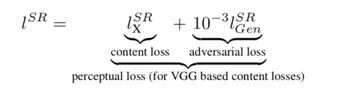

This Loss function was chosen that it measures the difference between the high-level features of two images, typically extracted from a pre-trained CNN. In our case the Feature Extractor is VGG and we use it to measure the output latent vector between the constructed Image Ihr and the Real Image Ilr

###- Content Loss
#### MSE loss:
Pixel-wise error between high resolution image and super resolved image (generated image) is given as below:

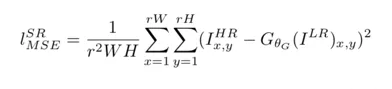

#### VGG loss:
 φ(i,j) indicates the feature map obtained by the j-th convolution (after activation) before the i-th maxpooling layer within the VGG19 network. VGG loss is defined as the euclidean distance between the feature representations of a reconstructed image and the reference image:

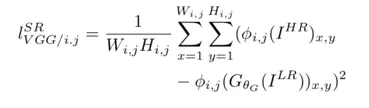


###- Adversarial loss
The generative loss is defined based on the probabilities of the discriminator over all training samples (N) :

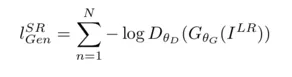<br>
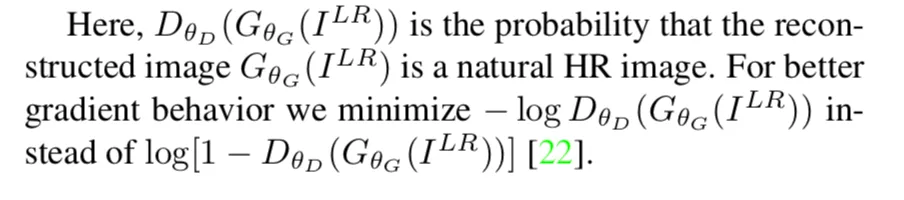

### Define Model Classes

In [12]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        return self.feature_extractor(img)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
        )

    def forward(self, x):
        return x + self.conv_block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))

        # Upsampling layers
        upsampling = []
        for out_features in range(2):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Tanh())
    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

### Train Super Resolution GAN (SRGAN)

In [13]:
# Initialize generator and discriminator
generator = GeneratorResNet()
discriminator = Discriminator(input_shape=(channels, *hr_shape))
feature_extractor = FeatureExtractor()

# Set feature extractor to inference mode
feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_content = torch.nn.L1Loss()

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    criterion_content = criterion_content.cuda()

# Load pretrained models
if load_pretrained_models:
    generator.load_state_dict(torch.load("../input/single-image-super-resolution-gan-srgan-pytorch/saved_models/generator.pth"))
    discriminator.load_state_dict(torch.load("../input/single-image-super-resolution-gan-srgan-pytorch/saved_models/discriminator.pth"))

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 150MB/s]


## Train Strategy
----
## Training Strategy Explanation

### Initialization

- **Losses and Counters**:
  - Initialize lists to store generator and discriminator losses during training and testing.
  - `train_counter` and `test_counter` are used to keep track of the training and testing steps.

- **Epoch Loop**:
  - Iterate over the number of epochs specified by `n_epochs`.

### Training Phase

- **Epoch Initialization**:
  - Initialize `gen_loss` and `disc_loss` to accumulate losses for the current epoch.

- **Training Loop**:
  - Loop over batches of images from the `train_dataloader`.
  - Use a progress bar (`tqdm`) to show training progress for the current epoch.

- **Model Preparation**:
  - Set both the generator and discriminator to training mode.

- **Input Configuration**:
  - Extract low-resolution (`imgs_lr`) and high-resolution (`imgs_hr`) images from the batch and convert them to tensors (`Variable`).

- **Adversarial Ground Truths**:
  - Create `valid` and `fake` labels for the discriminator's output, corresponding to real and fake images, respectively.

#### Train Generator

- **Zero Gradients**:
  - Clear gradients of the generator's optimizer (`optimizer_G`).

- **Generate High-Resolution Image**:
  - Generate a high-resolution image (`gen_hr`) from the low-resolution input using the generator.

- **Adversarial Loss**:
  - Compute the adversarial loss (`loss_GAN`) by passing the generated image through the discriminator and comparing with the `valid` labels.

- **Content Loss**:
  - Extract features from the generated and real high-resolution images using a pre-trained feature extractor.
  - Compute the content loss (`loss_content`) based on the difference between these features.

- **Total Generator Loss**:
  - Calculate the total loss for the generator (`loss_G`) as a combination of content loss and adversarial loss.
  - Backpropagate the loss and update the generator's weights.

#### Train Discriminator

- **Zero Gradients**:
  - Clear gradients of the discriminator's optimizer (`optimizer_D`).

- **Real and Fake Losses**:
  - Compute the loss for real images (`loss_real`) by passing real high-resolution images through the discriminator and comparing with `valid` labels.
  - Compute the loss for fake images (`loss_fake`) by passing generated high-resolution images through the discriminator and comparing with `fake` labels.

- **Total Discriminator Loss**:
  - Calculate the total loss for the discriminator (`loss_D`) as the average of real and fake losses.
  - Backpropagate the loss and update the discriminator's weights.

- **Loss Tracking**:
  - Accumulate the generator and discriminator losses for the current epoch and update the corresponding lists (`train_gen_losses`, `train_disc_losses`, `train_counter`).

### Testing Phase

- **Epoch Initialization**:
  - Initialize `gen_loss` and `disc_loss` to accumulate losses for the current epoch.

- **Testing Loop**:
  - Loop over batches of images from the `test_dataloader`.
  - Use a progress bar (`tqdm`) to show testing progress for the current epoch.

- **Model Preparation**:
  - Set both the generator and discriminator to evaluation mode.

- **Input Configuration**:
  - Extract low-resolution (`imgs_lr`) and high-resolution (`imgs_hr`) images from the batch and convert them to tensors (`Variable`).

- **Adversarial Ground Truths**:
  - Create `valid` and `fake` labels for the discriminator's output, corresponding to real and fake images, respectively.

#### Evaluate Generator

- **Generate High-Resolution Image**:
  - Generate a high-resolution image (`gen_hr`) from the low-resolution input using the generator.

- **Adversarial Loss**:
  - Compute the adversarial loss (`loss_GAN`) by passing the generated image through the discriminator and comparing with the `valid` labels.

- **Content Loss**:
  - Extract features from the generated and real high-resolution images using a pre-trained feature extractor.
  - Compute the content loss (`loss_content`) based on the difference between these features.

- **Total Generator Loss**:
  - Calculate the total loss for the generator (`loss_G`) as a combination of content loss and adversarial loss.

#### Evaluate Discriminator

- **Real and Fake Losses**:
  - Compute the loss for real images (`loss_real`) by passing real high-resolution images through the discriminator and comparing with `valid` labels.
  - Compute the loss for fake images (`loss_fake`) by passing generated high-resolution images through the discriminator and comparing with `fake` labels.

- **Total Discriminator Loss**:
  - Calculate the total loss for the discriminator (`loss_D`) as the average of real and fake losses.

- **Loss Tracking**:
  - Accumulate the generator and discriminator losses for the current epoch and update the corresponding lists (`test_gen_losses`, `test_disc_losses`).

- **Save Images**:
  - Randomly save a grid of images (real high-resolution, low-resolution, and generated high-resolution) for visualization.

### Model Checkpoints

- **Save Best Models**:
  - Save the generator and discriminator models if the current generator loss is the lowest observed so far.

This training strategy effectively combines adversarial and content losses to train a generator that can produce perceptually convincing high-resolution images while ensuring the discriminator accurately distinguishes between real and generated images.
----
----



## Evaluation Metrics

In the given training strategy for the SRGAN model, the following evaluation metrics are utilized:

1. **Adversarial Loss (GAN Loss)**
2. **Content Loss**

### Adversarial Loss (GAN Loss)

#### Description:
- **Adversarial Loss** is used to evaluate how well the generator is able to fool the discriminator. It measures the ability of the generator to create realistic high-resolution images that the discriminator cannot distinguish from real high-resolution images.
- In the context of GANs, the generator aims to minimize this loss while the discriminator aims to maximize it.

#### Formula:
\[ \text{loss}_{\text{GAN}} = \text{criterion}_{\text{GAN}}(\text{discriminator}(\text{gen\_hr}), \text{valid}) \]

#### Purpose:
- **Why It Is Used**: Adversarial loss encourages the generator to produce images that are not only high in resolution but also visually indistinguishable from real images. This adversarial process leads to more realistic image synthesis.

### Content Loss

#### Description:
- **Content Loss** measures the difference between the high-level features of the generated high-resolution image and the real high-resolution image. These features are extracted using a pre-trained feature extractor (often a deep neural network like VGG).
- This loss ensures that the generated image retains the content and structure of the original low-resolution image, making it perceptually similar to the real high-resolution image.

#### Formula:
\[ \text{loss}_{\text{content}} = \text{criterion}_{\text{content}}(\text{gen\_features}, \text{real\_features}.detach()) \]

#### Purpose:
- **Why It Is Used**: Content loss focuses on preserving the semantic and perceptual quality of the image. It ensures that the upscaled image looks similar to the original in terms of important features and structures, rather than just individual pixel values.

### Combined Loss

- The **total generator loss** is a combination of the content loss and the adversarial loss, weighted by a small factor (e.g., \(1e-3\)).
- The formula for the total loss is:
\[ \text{loss}_{G} = \text{loss}_{\text{content}} + 1e-3 \times \text{loss}_{\text{GAN}} \]

### Purpose of the Combined Loss:

- **Balancing Realism and Accuracy**: By combining both content loss and adversarial loss, the generator is trained to produce images that are not only realistic (as enforced by the adversarial loss) but also accurate in terms of content (as enforced by the content loss).
- **Enhanced Perceptual Quality**: This approach leads to enhanced perceptual quality, meaning the generated images are visually pleasing and structurally similar to the real images.

### Summary

The evaluation metrics used in the SRGAN training strategy ensure that the generated high-resolution images are both realistic and perceptually similar to the original high-resolution images. The adversarial loss pushes the generator to produce visually convincing images, while the content loss ensures the preservation of important structures and features. This combination results in high-quality image super-resolution.

### Techniques to avoid over fitting:
- Data Augmentation: Increase the amount of training data by creating modified versions of the existing data.
- Regularization: Add a penalty term to the loss function to reduce the complexity of the model. Examples include L1 and L2 regularization.
- Early Stopping: Stop training when the performance on a validation set stops improving.
- Dropout: Randomly ignore some neurons during training to prevent over-dependence on any one neuron.
- Cross-validation: Split the data into multiple folds for training and validation, and average the results.

In [14]:
train_gen_losses, train_disc_losses, train_counter = [], [], []
test_gen_losses, test_disc_losses = [], []
test_counter = [idx*len(train_dataloader.dataset) for idx in range(1, n_epochs+1)]

for epoch in range(n_epochs):

    ### Training
    gen_loss, disc_loss = 0, 0
    tqdm_bar = tqdm(train_dataloader, desc=f'Training Epoch {epoch} ', total=int(len(train_dataloader)))
    for batch_idx, imgs in enumerate(tqdm_bar):
        generator.train(); discriminator.train()
        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))
        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)

        ### Train Generator
        optimizer_G.zero_grad()
        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)
        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_hr), valid)
        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(imgs_hr)
        loss_content = criterion_content(gen_features, real_features.detach())
        # Total loss
        loss_G = loss_content + 1e-3 * loss_GAN
        loss_G.backward()
        optimizer_G.step()
        ### Train Discriminator
        optimizer_D.zero_grad()
        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(imgs_hr), valid)
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)
        # Total loss
        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        optimizer_D.step()

        gen_loss += loss_G.item()
        train_gen_losses.append(loss_G.item())
        disc_loss += loss_D.item()
        train_disc_losses.append(loss_D.item())
        train_counter.append(batch_idx*batch_size + imgs_lr.size(0) + epoch*len(train_dataloader.dataset))
        tqdm_bar.set_postfix(gen_loss=gen_loss/(batch_idx+1), disc_loss=disc_loss/(batch_idx+1))

    # Testing
    gen_loss, disc_loss = 0, 0
    tqdm_bar = tqdm(test_dataloader, desc=f'Testing Epoch {epoch} ', total=int(len(test_dataloader)))
    for batch_idx, imgs in enumerate(tqdm_bar):
        generator.eval(); discriminator.eval()
        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))
        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        ### Eval Generator
        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)
        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_hr), valid)
        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(imgs_hr)
        loss_content = criterion_content(gen_features, real_features.detach())
        # Total loss
        loss_G = loss_content + 1e-3 * loss_GAN

        ### Eval Discriminator
        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(imgs_hr), valid)
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)
        # Total loss
        loss_D = (loss_real + loss_fake) / 2

        gen_loss += loss_G.item()
        disc_loss += loss_D.item()
        tqdm_bar.set_postfix(gen_loss=gen_loss/(batch_idx+1), disc_loss=disc_loss/(batch_idx+1))

        # Save image grid with upsampled inputs and SRGAN outputs
        if random.uniform(0,1)<0.1:
            imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
            imgs_hr = make_grid(imgs_hr, nrow=1, normalize=True)
            gen_hr = make_grid(gen_hr, nrow=1, normalize=True)
            imgs_lr = make_grid(imgs_lr, nrow=1, normalize=True)
            img_grid = torch.cat((imgs_hr, imgs_lr, gen_hr), -1)
            save_image(img_grid, f"images/{batch_idx}.png", normalize=False)

    test_gen_losses.append(gen_loss/len(test_dataloader))
    test_disc_losses.append(disc_loss/len(test_dataloader))

    # Save model checkpoints
    if np.argmin(test_gen_losses) == len(test_gen_losses)-1:
        torch.save(generator.state_dict(), "saved_models/generator.pth")
        torch.save(discriminator.state_dict(), "saved_models/discriminator.pth")


Training Epoch 0 :   0%|          | 0/125 [00:00<?, ?it/s]

Testing Epoch 0 :   0%|          | 0/42 [00:00<?, ?it/s]

Training Epoch 1 :   0%|          | 0/125 [00:00<?, ?it/s]

Testing Epoch 1 :   0%|          | 0/42 [00:00<?, ?it/s]

In [15]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_counter, y=train_gen_losses, mode='lines', name='Train Generator Loss'))
fig.add_trace(go.Scatter(x=test_counter, y=test_gen_losses, marker_symbol='star-diamond',
                         marker_color='orange', marker_line_width=1, marker_size=9, mode='markers', name='Test Generator Loss'))
fig.update_layout(
    width=1000,
    height=500,
    title="Train vs. Test Generator Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Adversarial + Content Loss"),
fig.show()

In [16]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_counter, y=train_disc_losses, mode='lines', name='Train Discriminator Loss'))
fig.add_trace(go.Scatter(x=test_counter, y=test_disc_losses, marker_symbol='star-diamond',
                         marker_color='orange', marker_line_width=1, marker_size=9, mode='markers', name='Test Discriminator Loss'))
fig.update_layout(
    width=1000,
    height=500,
    title="Train vs. Test Discriminator Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Adversarial Loss"),
fig.show()

# Output Sample

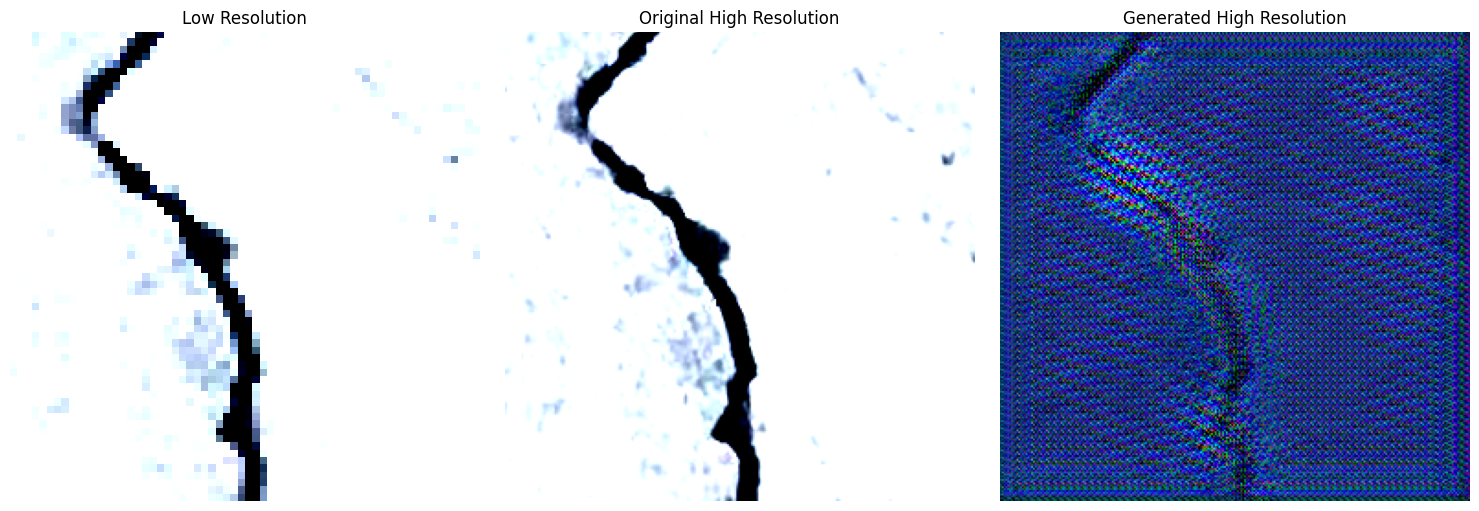

In [19]:

import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(test_dataloader)
images = next(dataiter)

imgs_lr = Variable(images["lr"].type(Tensor))
imgs_hr = Variable(images["hr"].type(Tensor))

with torch.no_grad():
    gen_hr = generator(imgs_lr)

imgs_lr_np = imgs_lr.detach().cpu().numpy()
imgs_hr_np = imgs_hr.detach().cpu().numpy()
gen_hr_np = gen_hr.detach().cpu().numpy()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axes[0].imshow(np.transpose(imgs_lr_np[0], (1, 2, 0)))
axes[0].set_title("Low Resolution")
axes[0].axis('off')

axes[1].imshow(np.transpose(imgs_hr_np[0], (1, 2, 0)))
axes[1].set_title("Original High Resolution")
axes[1].axis('off')

axes[2].imshow(np.transpose(gen_hr_np[0], (1, 2, 0)))
axes[2].set_title("Generated High Resolution")
axes[2].axis('off')

plt.tight_layout()
plt.show()


### the outpyt doesn't look as an high resolution because of the training resources I wasn't able to train on large dataset.

# Disclaimer

- Model and Equation Images are all from
 <a href="https://arxiv.org/abs/1609.04802">Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network [C. Ledig et al.]</a></center></h4>

- in decoration of the markdown Language used Chat-GPT.

- Perceptual Loss from <https://saturncloud.io/glossary/perceptual-loss-function/>
- Data From kaggle
- Main Resource  https://www.youtube.com/watch?v=nbRkLE2fiVI